<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "2E"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/2E/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


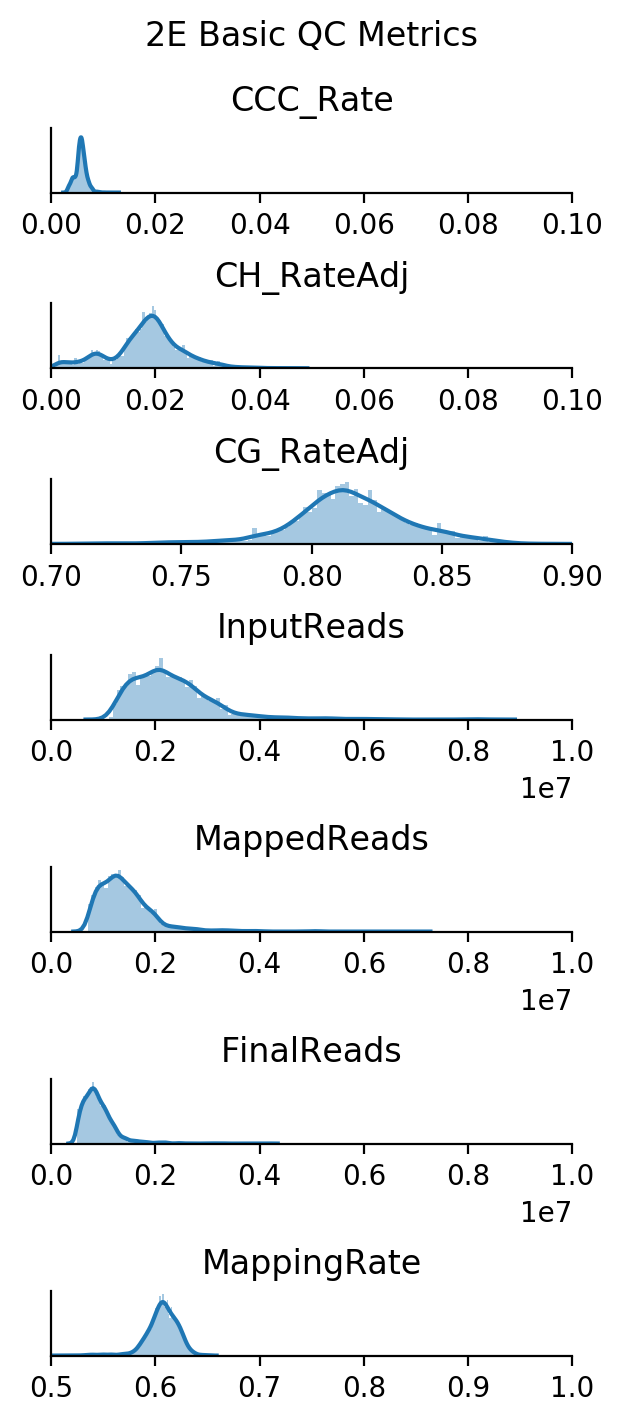

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

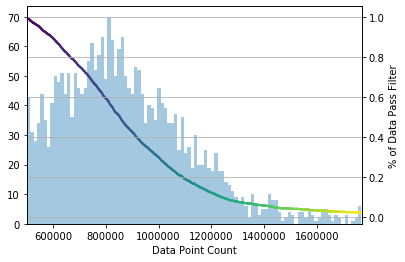

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2628/2628 (100.0%)
CG_RateAdj passed 2628/2628 (100.0%)
CH_RateAdj passed 2628/2628 (100.0%)
FinalReads passed 2628/2628 (100.0%)
MappingRate passed 2628/2628 (100.0%)
Overall passed 2628/2628 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180220 1402
180222 1226


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 326 84.9%
ad002 293 76.3%
ad004 348 90.6%
ad006 341 88.8%
ad007 332 86.5%
ad008 331 86.2%
ad010 340 88.5%
ad012 317 82.6%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
2E_M_0,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180220_2E...,0.00626,0.82512,0.82402,0.02722,0.02109,730605.0,1763140,1071910.0,2E,...,3.877697,3.290732,32.334202,-29.457988,OLF-Exc Bmpr1b,10.514030,-12.151004,-14.860111,-42.864948,True
2E_M_1,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180220_2E...,0.00603,0.81993,0.81884,0.02424,0.01832,672804.0,1611826,984930.0,2E,...,-3.843009,-17.650747,33.744172,-13.534998,MSN-D1 Ntn1,-11.904306,0.261986,20.314177,11.901969,True
2E_M_10,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180220_2E...,0.00614,0.84272,0.84175,0.02889,0.02289,871822.0,2221730,1352792.0,2E,...,22.162073,14.455119,29.514580,47.776149,L6b Nrp2,16.880903,1.135202,4.113570,9.159352,True
2E_M_100,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180220_2E...,0.00540,0.82291,0.82195,0.02130,0.01599,1039965.0,2712178,1633485.0,2E,...,2.715720,-1.695468,-17.136472,42.877841,Foxp2 Dchs2,-2.698195,-2.787540,-5.318180,-20.874507,True
2E_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180220_2E...,0.00447,0.78941,0.78846,0.01421,0.00978,1304187.0,3385372,2111184.0,2E,...,1.733359,2.198423,45.983442,-29.523632,OLF-Exc Bmpr1b,15.095961,-11.286705,11.089410,-50.384169,True
2E_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180220_2E...,0.00556,0.82736,0.82639,0.02538,0.01993,731068.0,2145704,1172412.0,2E,...,2.191397,4.314252,36.348330,-24.405556,OLF-Exc Bmpr1b,8.035596,-10.083381,-2.598616,-25.762502,True
2E_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180220_2E...,0.00559,0.84655,0.84569,0.02359,0.01810,642561.0,1883904,1032445.0,2E,...,3.616415,6.119938,30.026437,-22.599875,OLF-Exc Rmst,7.514806,-11.660904,-19.001320,-21.799856,True
2E_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180220_2E...,0.00688,0.85693,0.85594,0.03354,0.02684,743761.0,2176214,1207312.0,2E,...,24.386076,11.331787,-17.672486,-44.492062,CT-L6 Megf9,1.540644,-18.658003,2.092300,-34.611228,True
2E_M_1005,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180220_2E...,0.00570,0.80991,0.80882,0.02591,0.02033,688134.0,2058806,1136828.0,2E,...,2.022905,4.025692,38.275891,-24.539440,OLF-Exc Bmpr1b,11.907322,-12.043304,0.002867,-28.395483,True
2E_M_1006,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180220_2E...,0.00580,0.82026,0.81921,0.02593,0.02025,685590.0,2127150,1138565.0,2E,...,2.486321,4.668949,38.381583,-21.560982,OLF-Exc Bmpr1b,11.538416,-13.667549,-4.511019,-29.582924,True
